In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle
import scan
import simulate_data
import h5py
import sys
np.set_printoptions(threshold=sys.maxsize)


In [11]:
def get_imgs(N, pattern_template):
    if len(pattern_template) == 0:
        print('FAIL')
        return pattern_template, None
    
    win_size = (N,1+max([max(k[:,0]) for k in pattern_template]))
    pattern_img = np.zeros((len(pattern_template),*win_size))
    for p,pattern in enumerate(pattern_template):
        for (i,j) in pattern:
            pattern_img[p,j,i] = 1
            
    pattern_img = pattern_img.transpose((1,2,0))
    
    return pattern_template, pattern_img

In [12]:
f = h5py.File(r'C:/Users/miles/Projects/datasets/heidelberg/shd_test.h5')

In [13]:
counts = []
for k in np.unique(f['labels']):
    counts.append(list(f['labels']).count(k))
np.array(counts)

array([103, 108, 105, 102, 116, 110, 109, 109, 114, 103, 122, 121, 121,
       120, 115, 112, 118, 121, 123, 112])

In [14]:
counts = []
for k in np.unique(f['extra']['speaker']):
    counts.append(list(f['extra']['speaker']).count(k))
np.array(counts)

array([ 47,  47,  52,  38, 900, 940,  23,  40,  41,  43,  41,  52])

In [15]:
# if I want to look at speakers, maybe 4 and 5 are the best ones to consider?

In [16]:
np.sum((np.array(f['labels'])==0) & (np.array(f['extra']['speaker']) == 4))

42

In [17]:
np.sum(np.array(f['labels'])==0), np.sum(np.array(f['extra']['speaker']) == 4)

(103, 900)

In [141]:

idc = np.where((np.array(f['labels'])==0) & (np.array(f['extra']['speaker']) == 4))[0]
idc

array([   6,   26,   43,   64,  200,  203,  209,  245,  420,  447,  487,
        495,  653,  658,  721,  763,  805, 1010, 1057, 1105, 1117, 1159,
       1250, 1292, 1378, 1416, 1428, 1438, 1503, 1573, 1709, 1714, 1729,
       1750, 1830, 1838, 1909, 1932, 1958, 2090, 2126, 2207], dtype=int64)

In [19]:
len(idc)

42

In [145]:
np.concatenate((idc1, idc2))

array([ 64, 200, 203, 209, 245, 420, 447, 487, 495, 653,   8,   9,  10,
        17,  24,  25,  29,  32,  33,  34], dtype=int64)

In [157]:
np.array(f['labels'])[idc2]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=uint16)

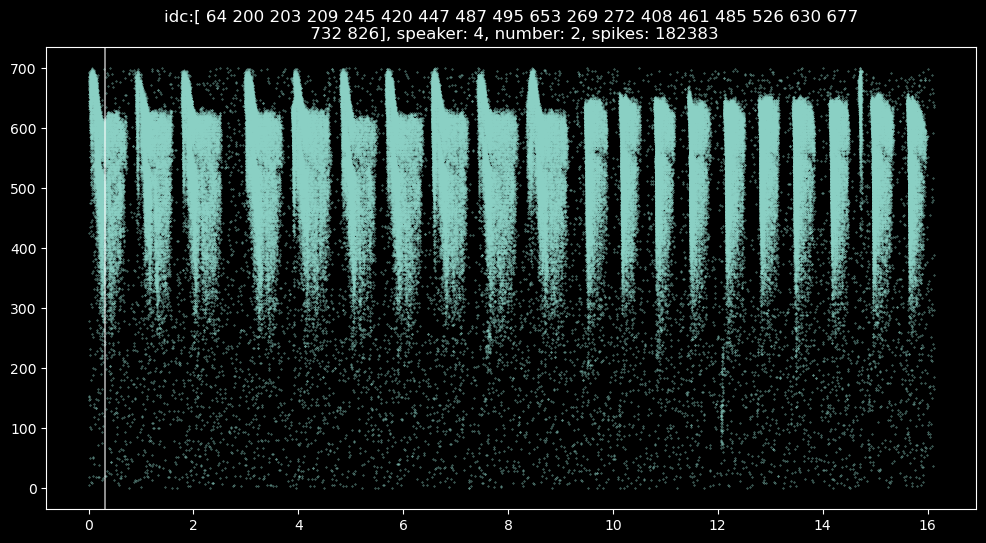

In [156]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))

idc = np.where((np.array(f['labels'])==0) & (np.array(f['extra']['speaker']) == 4))[0][:3]

D=5/1000
times = np.array([0])
units = np.array([])
for i in idc:
    times = np.hstack((times, np.max(times)+f['spikes']['times'][i]))
    units = np.hstack((units, f['spikes']['units'][i]))
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
units = units.astype('int')
times = np.delete(times,0)
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

plt.title(f'idc:{idc}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.show()

In [107]:
window_starts

[0, 0.89599609375, 1.783203125]

In [80]:
# Convert the data into something that is easily readable by my parameter scan algo.
filename = f'combined-{idc}-{int(D*1000)}'

if not os.path.isfile(''.join((os.getcwd(),f'\\{filename}.pkl'))):
    pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = scan.scan_raster((times*1000).astype('int'), units.astype('int'),window_dim=int(D*1000))
    print(f'run_time: {window_time+cluster_time+sequence_time} s')

    results_scan = {
        'pattern_template':pattern_template,
        'sublist_keys_filt':sublist_keys_filt,
        'window_time':window_time,
        'cluster_time':cluster_time,
        'sequence_time':sequence_time
    }

    import pickle 
    with open(f'{filename}.pkl', 'wb') as file:  # open a text file
        pickle.dump(results_scan, file) # serialize the list
    file.close()
else:
    with open(f'{filename}.pkl', 'rb') as file:
        results_scan = pickle.load(file)
    file.close()
    print(f'{filename}.pkl loaded!')

    

50173 Windows
38 patterns found...... 97% 10.01 | opt_cutoff - 1.68 | most_detections - 10tections - 10
run_time: 381.7735483646393 s


In [65]:
import numpy as np

def create_window_vector(times, window_starts):
    # Initialize an array of zeros with the same length as the window_starts
    window_vector = np.zeros(len(window_starts), dtype=int)

    # Iterate through the times and check which window(s) they belong to
    for time in times:
        for i, window_start in enumerate(window_starts):
            if window_start <= time < (window_starts[i + 1] if i + 1 < len(window_starts) else float('inf')):
                window_vector[i] = 1

    return window_vector


[0 1 1]


In [541]:
filename = 'combined-[591 639   9]-5'

In [542]:
with open(f'{filename}.pkl', 'rb') as file:
        results_scan = pickle.load(file)

In [543]:
pattern_template, sublist_keys_filt, window_time, cluster_time, sequence_time = results_scan.values()
total_time = window_time+cluster_time+sequence_time
print(total_time)

71.51841926574707


In [544]:
np.mean([226,164,389,69,71]), np.std([226,164,389,69,71])

(183.8, 118.47598912859938)

In [546]:
np.mean([363,319]), np.std([363,319]) # 10 windows

(341.0, 22.0)

In [523]:
len(pattern_template)

400

In [524]:
np.array(f['labels'])[[6, 26, 43,64,200]]

array([0, 0, 0, 0, 0], dtype=uint16)

In [526]:
np.mean([262,319,400,218,205]), np.std([262,319,400,218,205])

(280.8, 71.70885579898763)

In [525]:
np.array(f['extra']['speaker'])[[6, 26, 43,64,200]]

array([4, 4, 4, 4, 4], dtype=uint16)

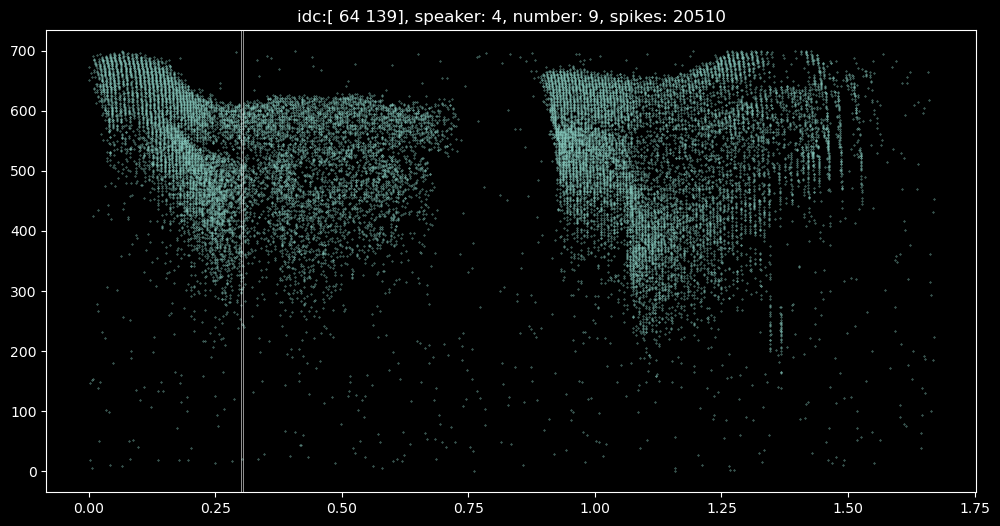

In [196]:
###### plt.style.use('dark_background')
plt.figure(figsize=(12,6))

idc1 = np.where((np.array(f['labels'])==0) & (np.array(f['extra']['speaker']) == 4))[0][3:4]
idc2 = np.where((np.array(f['labels'])==9) & (np.array(f['extra']['speaker']) == 4))[0][3:4]
idc = np.concatenate((idc1, idc2))

D=5/1000
times = np.array([0])
units = np.array([])
window_starts = []
for i in idc:
    window_starts.append(np.max(times))
    times = np.hstack((times, np.max(times)+f['spikes']['times'][i]))
    units = np.hstack((units, f['spikes']['units'][i]))
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
units = units.astype('int')
times = np.delete(times,0)
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

plt.title(f'idc:{idc}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.show()

In [405]:
np.array(f['labels'])[idc2],idc

(array([9, 3], dtype=uint16), array([ 6, 29, 32], dtype=int64))

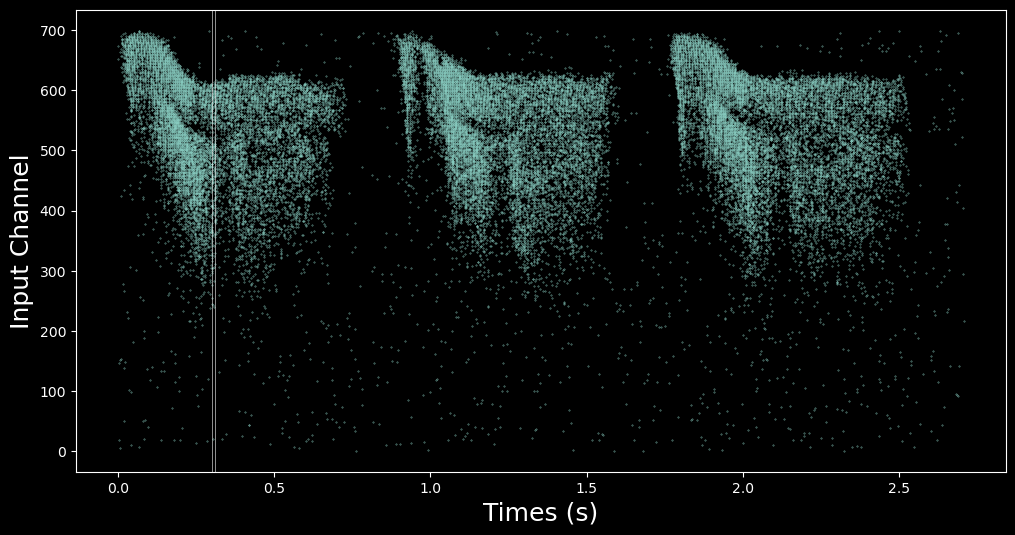

In [451]:
%matplotlib inline
###### plt.style.use('dark_background')
plt.figure(figsize=(12,6))
fontsize=18

idc1 = np.where((np.array(f['labels'])==0) & (np.array(f['extra']['speaker']) == 4))[0][3:6]
# idc2 = np.where((np.array(f['labels'])!=0) & (np.array(f['extra']['speaker']) == 4))[0][9:11]
idc = np.concatenate((idc1, idc2))

D=10/1000
times = np.array([0])
units = np.array([])
window_starts = []
for i in idc1:
    window_starts.append(np.max(times))
    times = np.hstack((times, np.max(times)+f['spikes']['times'][i]))
    units = np.hstack((units, f['spikes']['units'][i]))
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
units = units.astype('int')
times = np.delete(times,0)
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)
plt.xlabel('Times (s)',fontsize=fontsize)
plt.ylabel('Input Channel',fontsize=fontsize)

# plt.title(f'Spoken Digit 0')
plt.show()

In [452]:
pattern_template_copy, pattern_img = get_imgs(1+max(units.astype('int')),pattern_template)

raster = np.zeros((max((times*1000).astype('int'))+1, 1+max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]]=1
print('done')

D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/len(pattern_template[j])

(2708, 700) (700, 39, 319)
done


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:19<00:00,  4.00it/s]


In [453]:
th=0.5

In [454]:
th=1

In [455]:
counts = np.array([list(np.where(sanity_check>=th)[1]).count(k) for k in np.unique(np.where(sanity_check>=th)[1])])
occurrences = [np.where(sanity_check>=th)[0][np.array(np.where(sanity_check>=th))[1] ==k] for k in np.unique(np.where(sanity_check>=th)[1])]
patterns = np.unique(np.where(sanity_check>=th)[1])
pattern_template = np.array(pattern_template,dtype='object')
np.array(patterns[counts>2]), np.array(counts[counts>2]), np.array([len(k) for k in pattern_template[patterns[counts>2]]])

(array([], dtype=int64), array([], dtype=float64), array([], dtype=float64))

In [457]:
scores = np.array([create_window_vector(k,np.array(window_starts)*1000) for k in occurrences])

In [458]:
scores

array([], dtype=float64)

In [323]:
i=8
len(pattern_template[i]),np.sum(pattern_img[...,i],axis=(0,1))

(2, 2.0)

KeyboardInterrupt: 

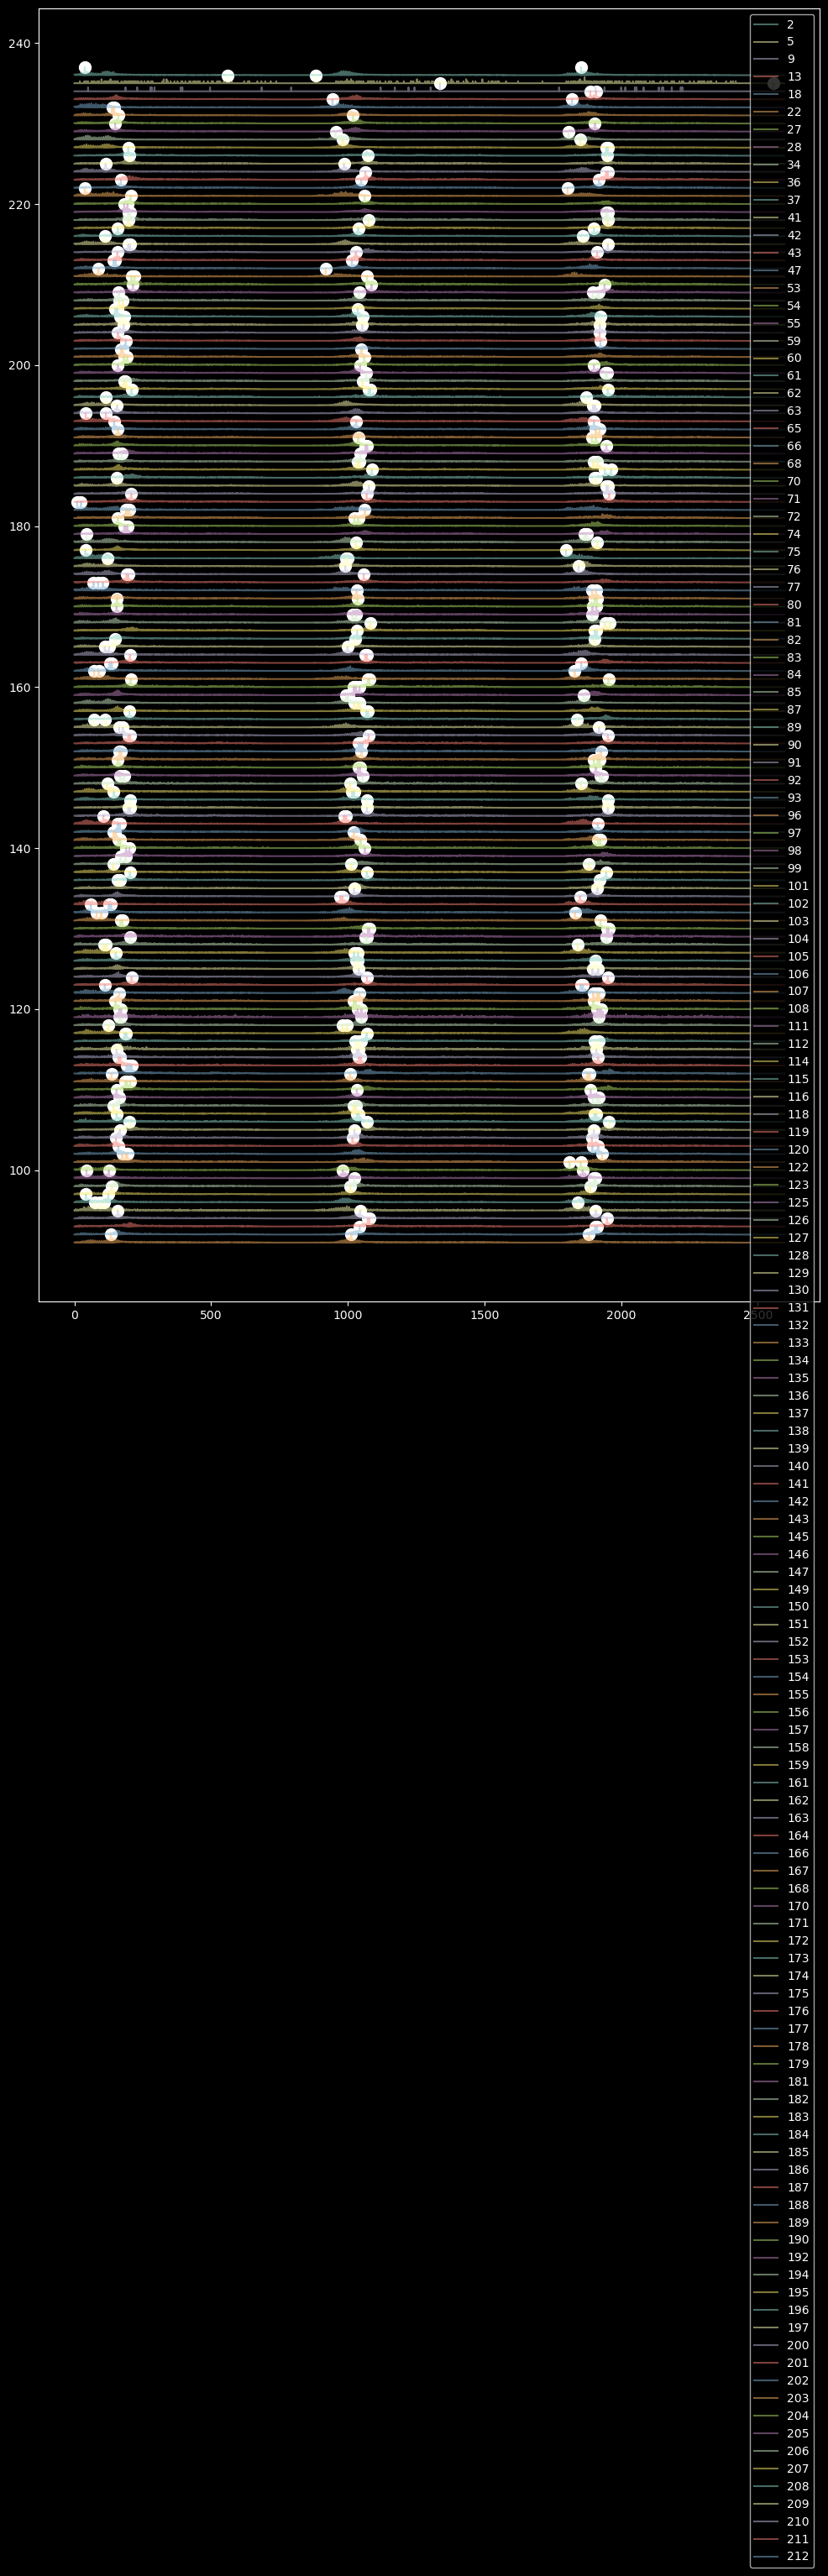

In [354]:
plt.figure(figsize=(12,20))
for i,k in enumerate(patterns[counts>2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>2])-i,label=k,alpha=0.5)
    plt.scatter(np.where(sanity_check[:,k]==1)[0], np.ones_like(np.where(sanity_check[:,k]==1)[0])+len(patterns[counts>2])-i,c='white',s=100)
    plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
principalComponents = pca.fit_transform(x)

In [367]:
th=1

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check>=th), s=5)
y,x = patterns[counts>=2][np.where(sanity_check[:,patterns[counts>=2]]>=th)[1]], np.where(sanity_check[:,patterns[counts>=2]]>=th)[0]
plt.scatter(x,y, c='white',s=5,alpha=0.5)
plt.title()
plt.show()

In [376]:
len([len(pattern_template[i]) for i in y]), len(x), len(y)

(771, 771, 771)

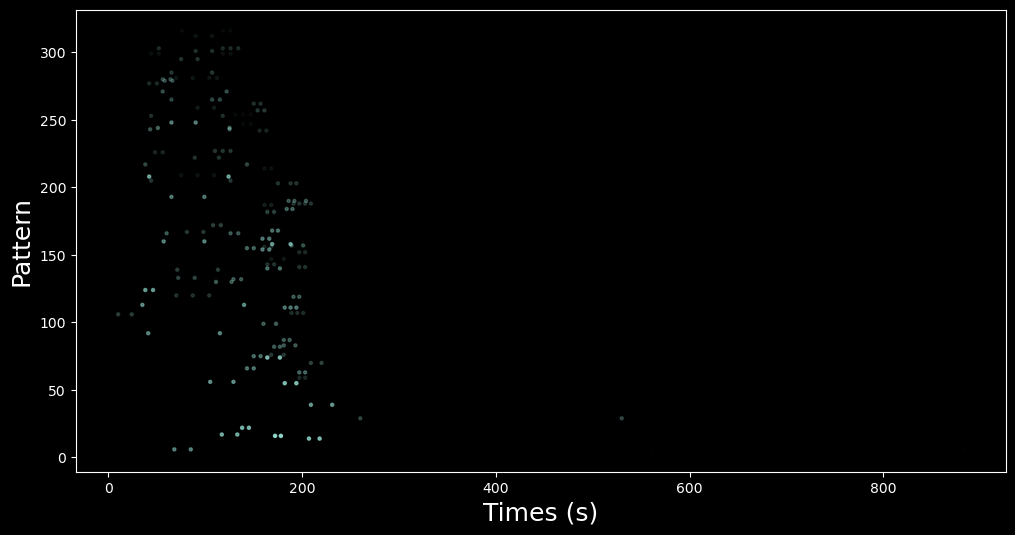

In [406]:
plt.figure(figsize=(12,6))
# plt.scatter(*np.where(sanity_check>=th), s=5)
y,x = patterns[counts>=2][np.where(sanity_check[:,patterns[counts>=2]]>=th)[1]], np.where(sanity_check[:,patterns[counts>=2]]>=th)[0]
plt.scatter(x,y,s=5,alpha=np.array([len(pattern_template[i]) for i in y])/np.max([len(pattern_template[i]) for i in y]))
# plt.title()
plt.xlabel('Times (s)',fontsize=fontsize)
plt.ylabel('Pattern',fontsize=fontsize)
plt.show()

Text(0.5, 0, 'Times (ms)')

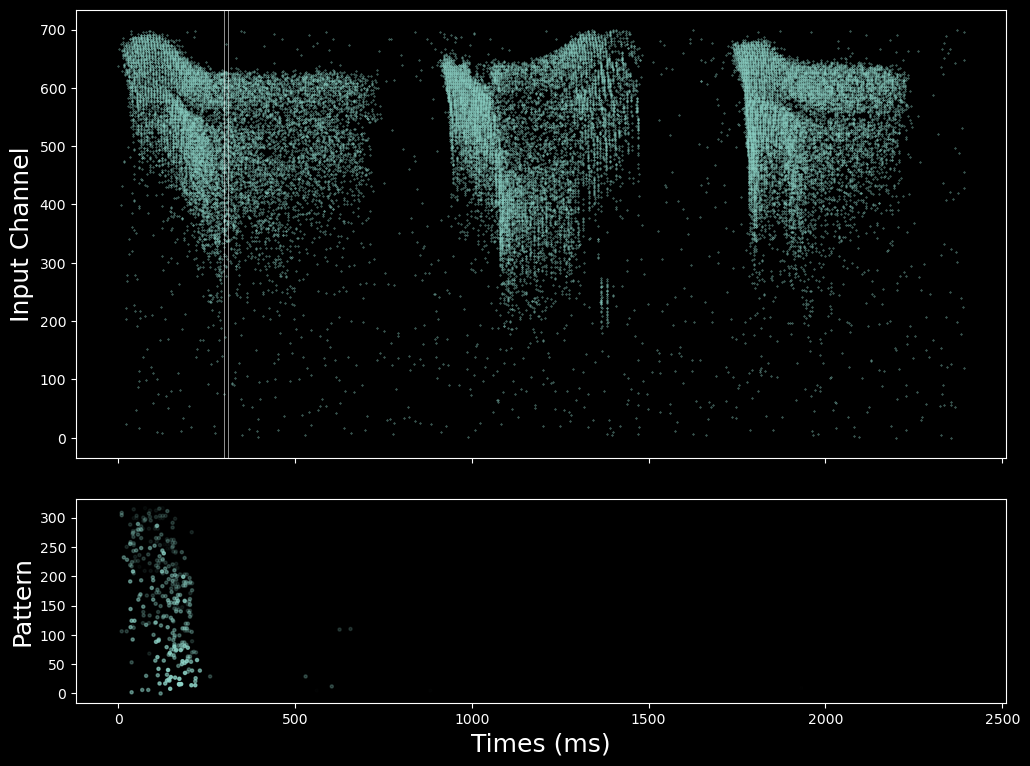

In [416]:
fig,ax = plt.subplot_mosaic('A;A;B',figsize=(12,9),sharex=True)
ax['A'].scatter(times*1000 ,units,s=0.1,alpha=0.9)
ax['A'].axvline(0.3*1000,linewidth=0.4,label = '10ms window')
ax['A'].axvline(0.3*1000+D*1000,linewidth=0.4)
ax['A'].set_ylabel('Input Channel',fontsize=fontsize)


y,x = patterns[counts>=1][np.where(sanity_check[:,patterns[counts>=1]]>=th)[1]], np.where(sanity_check[:,patterns[counts>=1]]>=th)[0]
ax['B'].scatter(x,y,s=5,alpha=np.array([len(pattern_template[i]) for i in y])/np.max([len(pattern_template[i]) for i in y]))

ax['B'].set_ylabel('Pattern',fontsize=fontsize)
ax['B'].set_xlabel('Times (ms)',fontsize=fontsize)

In [445]:
len(times)

29631

Text(0.5, 0, 'Times (s)')

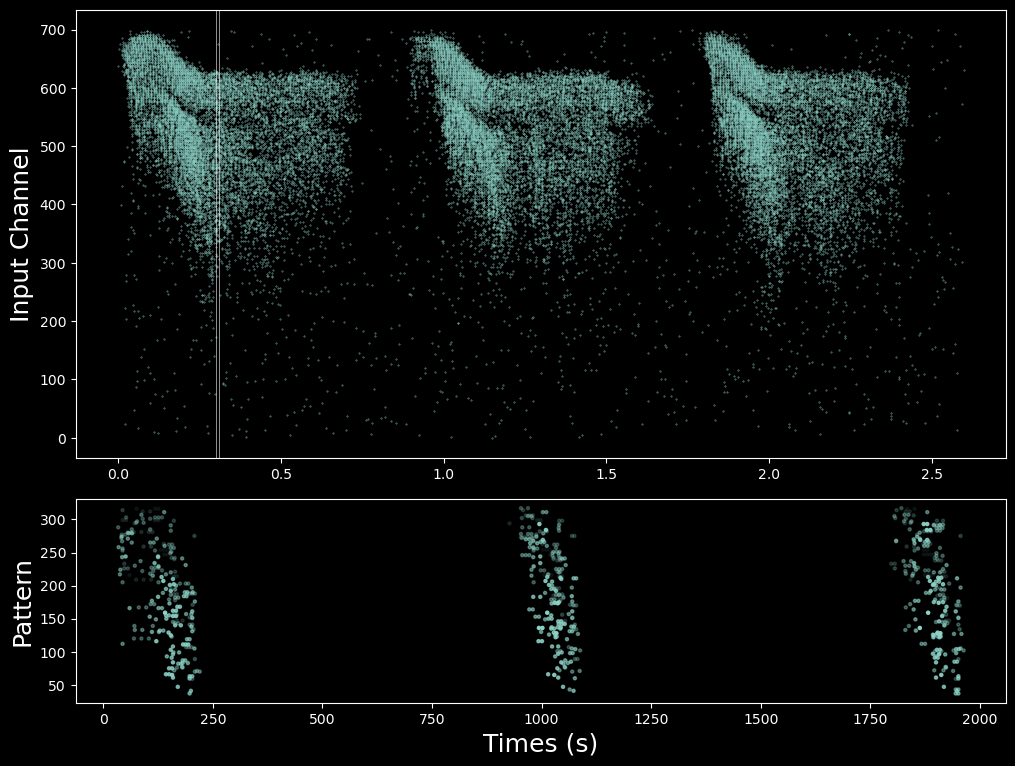

In [430]:
fig,ax = plt.subplot_mosaic('A;A;B',figsize=(12,9))
ax['A'].scatter(times ,units,s=0.1,alpha=0.9)
ax['A'].axvline(0.3,linewidth=0.4,label = '10ms window')
ax['A'].axvline(0.3+D,linewidth=0.4)
ax['A'].set_ylabel('Input Channel',fontsize=fontsize)


y,x = patterns[counts>2][np.where(sanity_check[:,patterns[counts>2]]>=th)[1]], np.where(sanity_check[:,patterns[counts>2]]>=th)[0]
ax['B'].scatter(x,y,s=5,alpha=np.array([len(pattern_template[i]) for i in y])/np.max([len(pattern_template[i]) for i in y]))

ax['B'].set_ylabel('Pattern',fontsize=fontsize)
ax['B'].set_xlabel('Times (s)',fontsize=fontsize)

In [448]:
times1, units1 = times.copy(), units.copy()
x1,y1 = x.copy(),y.copy()

In [463]:
%matplotlib qt
plt.style.use('default')
fig,ax = plt.subplot_mosaic('AC;AC;BD',figsize=(12,8),sharex=True)

ax['C'].scatter(times*1000 ,units,s=0.1,alpha=0.9)
# ax['C'].axvline(0.3*1000,linewidth=0.4,label = '10ms window')
# ax['C'].axvline(0.3*1000+D*1000,linewidth=0.4)
# ax['C'].set_title(f'Digits: 0, 9, 3')
# ax['C'].set_ylabel('Input Channel',fontsize=fontsize)


y,x = patterns[counts>=1][np.where(sanity_check[:,patterns[counts>=1]]>=th)[1]], np.where(sanity_check[:,patterns[counts>=1]]>=th)[0]
# ax['D'].scatter(x,y,s=5,alpha=np.array([len(pattern_template[i]) for i in y])/np.max([len(pattern_template[i]) for i in y]))

# ax['D'].set_ylabel('Pattern',fontsize=fontsize)
ax['D'].set_xlabel('Times (ms)',fontsize=fontsize)


# ax['A'].set_title(f'Digits: 0, 0, 0')
ax['A'].scatter(times1*1000 ,units1,s=0.1,alpha=0.9)
# ax['A'].axvline(0.3*1000,linewidth=0.4,label = '10ms window')
# ax['A'].axvline(0.3*1000+D*1000,linewidth=0.4)
ax['A'].set_ylabel('Input Channel',fontsize=fontsize)


# y,x = patterns[counts>0][np.where(sanity_check[:,patterns[counts>0]]>=th)[1]], np.where(sanity_check[:,patterns[counts>0]]>=th)[0]
ax['B'].scatter(x1,y1,s=5,alpha=np.array([len(pattern_template[i]) for i in y1])/np.max([len(pattern_template[i]) for i in y1]))

ax['B'].set_ylabel('Pattern',fontsize=fontsize)
ax['B'].set_xlabel('Times (ms)',fontsize=fontsize)
plt.tight_layout()

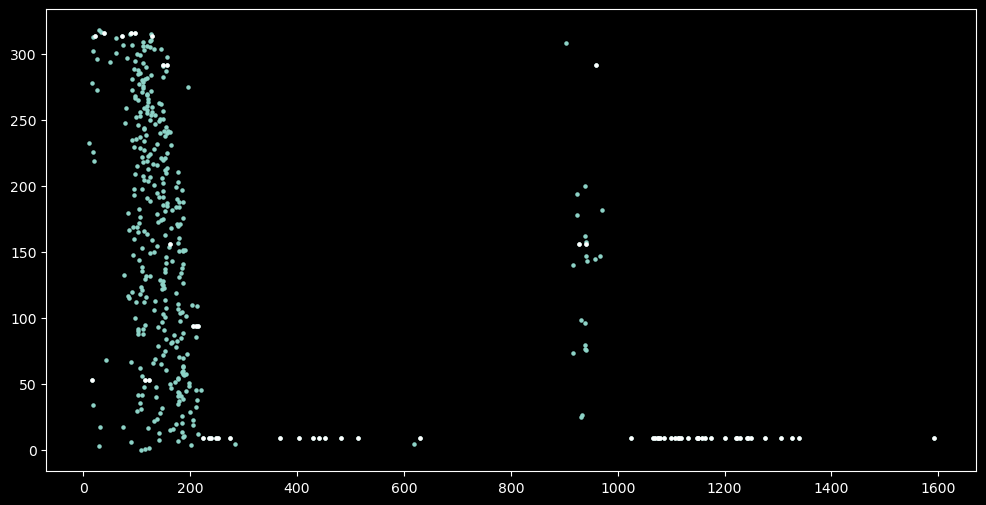

In [200]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>2][np.where(sanity_check[:,patterns[counts>2]]==1)[1]], np.where(sanity_check[:,patterns[counts>2]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

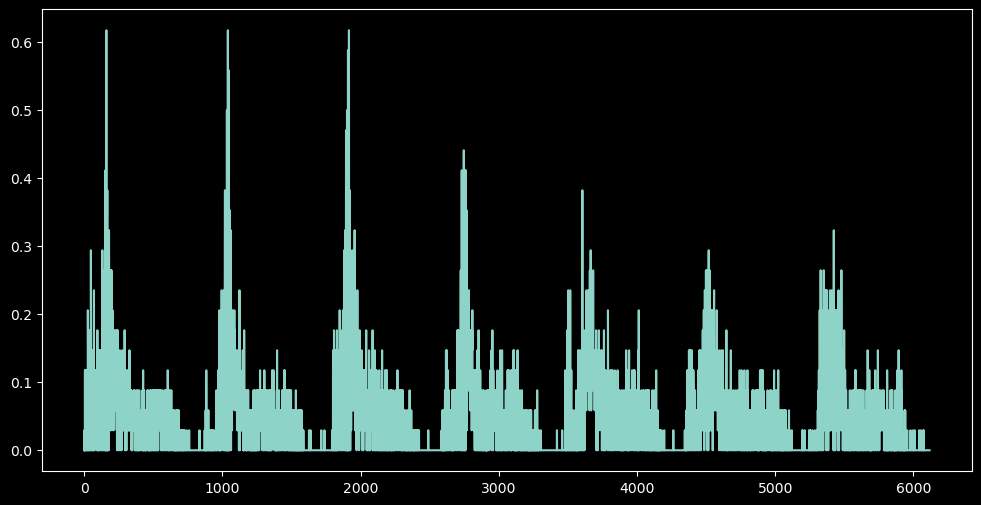

In [215]:
plt.figure(figsize=(12,6))
plt.plot(sanity_check[:,298])
plt.show()

In [ ]:
create_window_vector(np.where(sanity_check==1))

In [79]:
np.where(sanity_check==1)[0][np.array(np.where(sanity_check==1))[1] ==]

array([ 224,  252,  273,  336,  378,  398,  403,  450,  460,  494,  503,
        578,  831, 1044, 1074, 1144, 1161, 1175, 1213, 1305, 1357, 1361,
       1378, 1386, 2000, 2046, 2050, 2115, 2152, 2169, 2195, 2202, 2220,
       2228, 2230, 2232, 2257, 2318, 2329, 2337], dtype=int64)

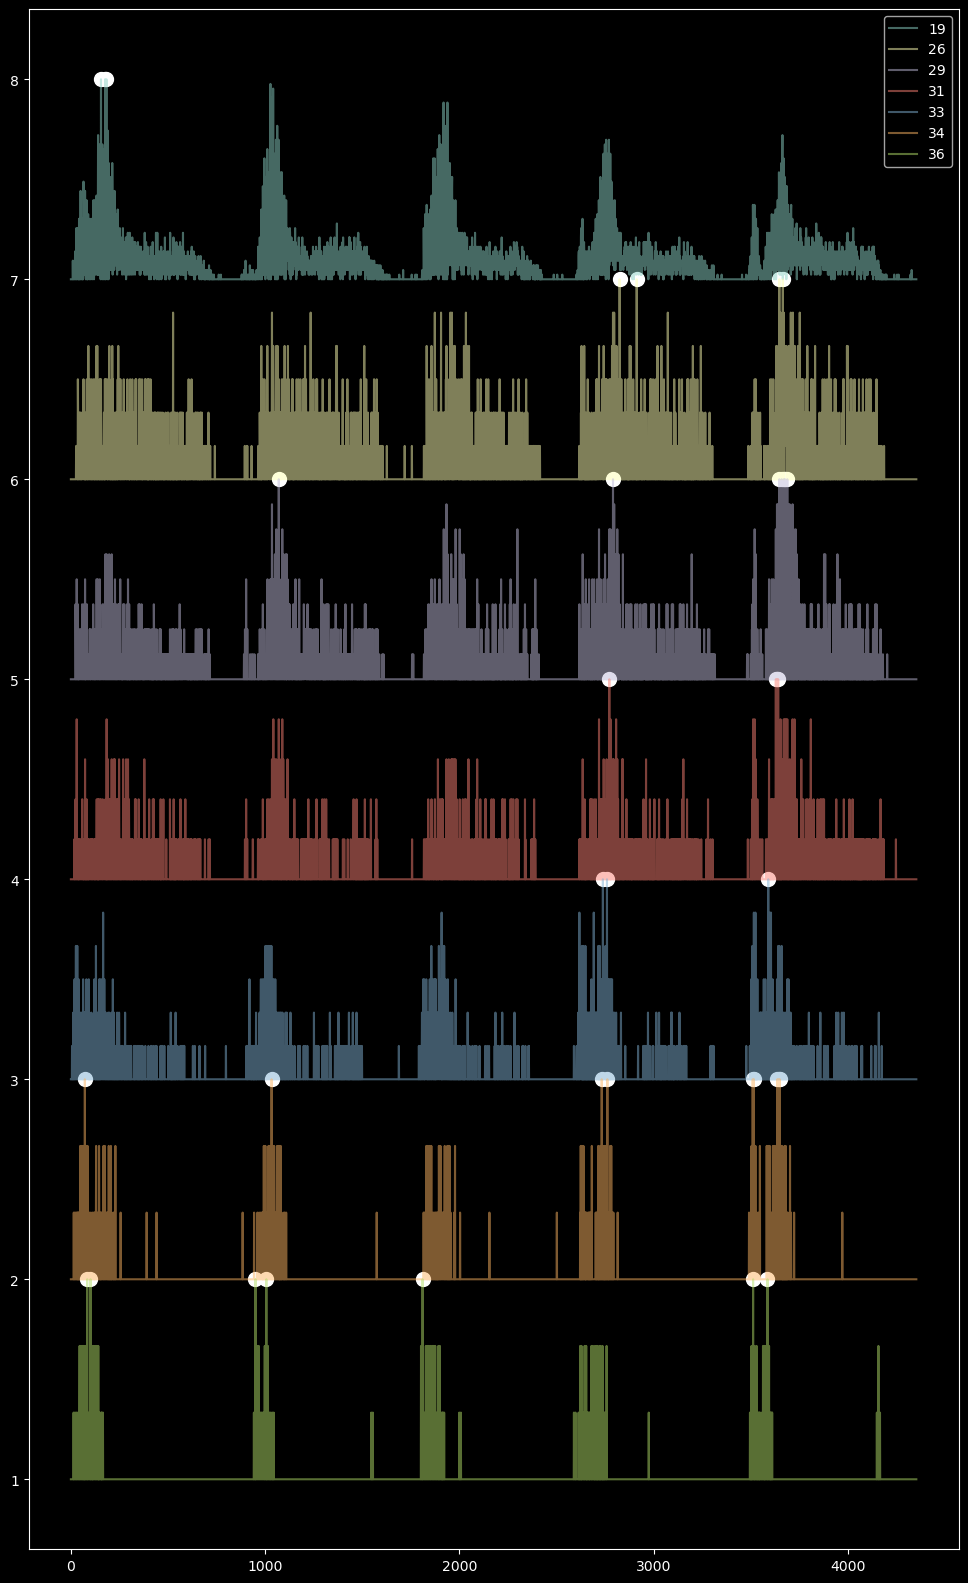

In [85]:
plt.figure(figsize=(12,20))
for i,k in enumerate(patterns[counts>2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>2])-i,label=k,alpha=0.5)
    plt.scatter(np.where(sanity_check[:,k]==1)[0], np.ones_like(np.where(sanity_check[:,k]==1)[0])+len(patterns[counts>2])-i,c='white',s=100)
    plt.legend()
plt.show()

# Below here was just tested on 3 stitched digits

In [60]:
pattern_template_copy, pattern_img = get_imgs(1+max(units.astype('int')),pattern_template)

raster = np.zeros((max((times*1000).astype('int'))+1, 1+max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]-1]=1
print('done')

D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

(2598, 700) (700, 19, 363)
done


  0%|                                                                                          | 0/363 [00:00<?, ?it/s]C:\Users\miles\AppData\Local\Temp\ipykernel_12808\2679264454.py:14: RuntimeWarning: invalid value encountered in divide
  sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])
100%|████████████████████████████████████████████████████████████████████████████████| 363/363 [00:26<00:00, 13.47it/s]


In [61]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
np.array(patterns[counts>2]), np.array(counts[counts>2]), np.array([len(k) for k in pattern_template[patterns[counts>2]]])

(array([  1,   8,  10,  18,  25,  26,  30,  32,  50,  54,  59,  82,  96,
        100, 130, 174, 197, 199, 250, 258, 281, 308, 317, 336], dtype=int64),
 array([ 3, 45,  3,  3,  3,  3, 24,  3,  3,  3,  3,  3,  4,  3,  3,  3,  5,
         3,  5,  3,  3,  8,  3,  4]),
 array([92,  2, 33, 70, 41, 46,  1, 79, 67, 51, 16, 66, 32, 46, 42,  6, 80,
        42, 95, 12, 38, 18, 45, 19]))

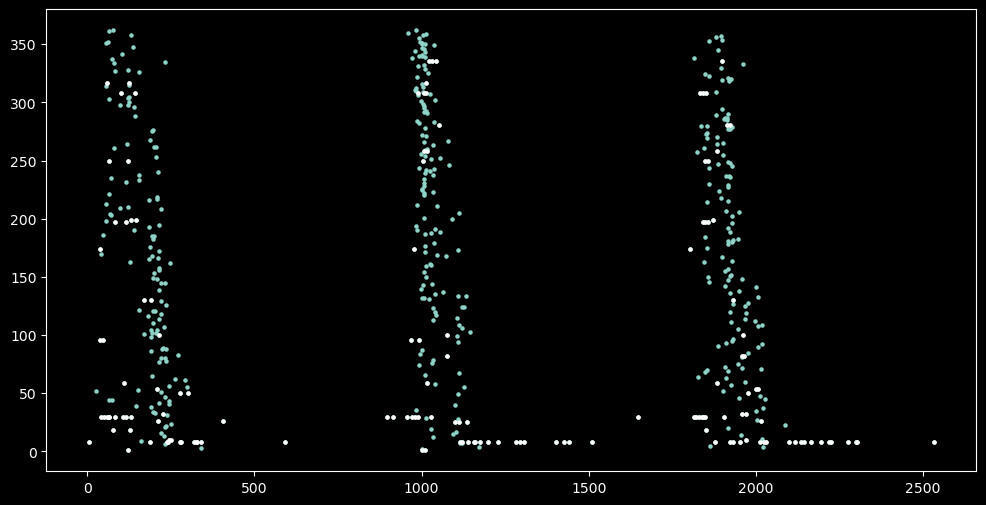

In [64]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>2][np.where(sanity_check[:,patterns[counts>2]]==1)[1]], np.where(sanity_check[:,patterns[counts>2]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

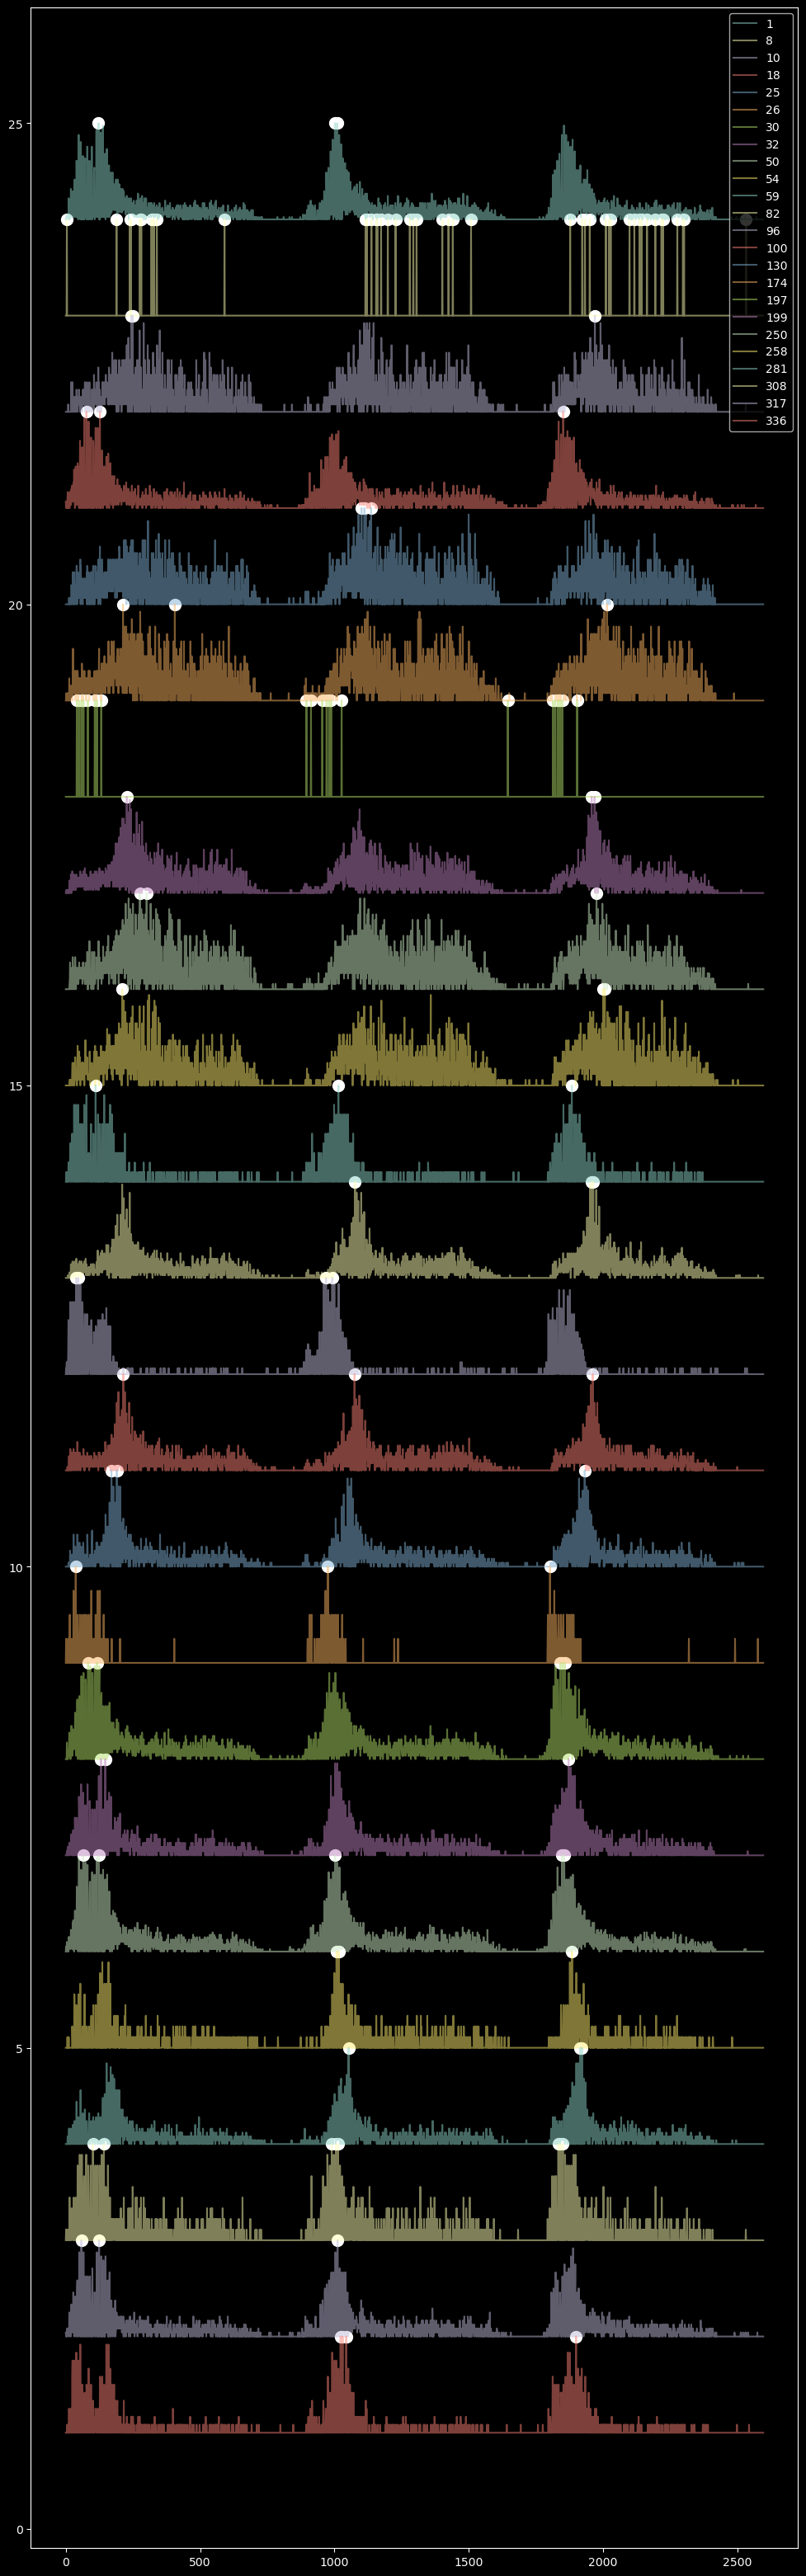

In [77]:
plt.figure(figsize=(12,40))
for i,k in enumerate(patterns[counts>2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>2])-i,label=k,alpha=0.5)
    plt.scatter(np.where(sanity_check[:,k]==1)[0], np.ones_like(np.where(sanity_check[:,k]==1)[0])+len(patterns[counts>2])-i,c='white',s=100)
    plt.legend()
plt.show()

# Let's see what happens when we convolve these patterns on spoken digits for which it wasn't trained

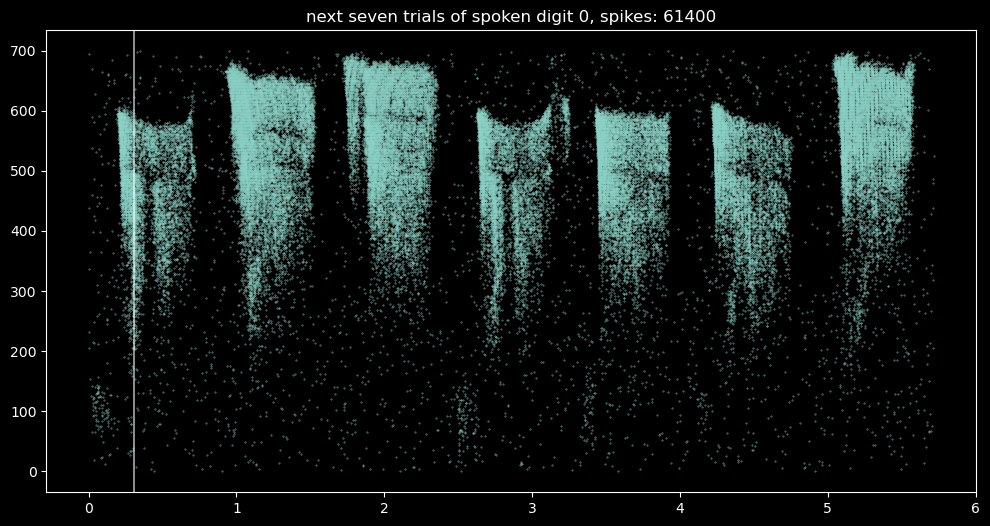

In [65]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))

idc = np.where((np.array(f['labels'])==0))[0][3:10]

D=5/1000
times = np.array([0])
units = np.array([])
for i in idc:
    times = np.hstack((times, np.max(times)+f['spikes']['times'][i]))
    units = np.hstack((units, f['spikes']['units'][i]))
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
units = units.astype('int')
times = np.delete(times,0)
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

# plt.title(f'idc:{idc}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.title(f'next seven trials of spoken digit 0, spikes: {len(times)}')

plt.show()

In [67]:
raster = np.zeros((max((times*1000).astype('int'))+1, 1+max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]-1]=1
print('done')

D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

(5719, 700) (700, 19, 400)
done


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:09<00:00,  5.74it/s]


In [68]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
np.array(patterns[counts>=2]), np.array(counts[counts>=2]), np.array([len(k) for k in pattern_template[patterns[counts>=2]]])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  13,  16,  17,  19,
         20,  23,  24,  26,  29,  30,  32,  33,  34,  35,  37,  40,  44,
         45,  47,  48,  49,  52,  55,  56,  57,  58,  59,  62,  63,  64,
         69,  70,  72,  73,  77,  82,  83,  84,  89,  91,  95,  96,  98,
        100, 101, 103, 105, 110, 111, 113, 114, 115, 118, 121, 122, 123,
        124, 125, 126, 129, 133, 135, 136, 139, 143, 146, 149, 153, 155,
        159, 161, 162, 164, 165, 167, 170, 171, 172, 174, 176, 179, 181,
        183, 184, 185, 186, 187, 189, 192, 193, 194, 197, 199, 201, 203,
        208, 209, 211, 213, 214, 218, 219, 221, 222, 223, 224, 227, 229,
        231, 232, 234, 239, 241, 242, 246, 247, 252, 253, 254, 255, 256,
        258, 262, 265, 266, 269, 274, 275, 276, 278, 281, 283, 289, 293,
        296, 297, 299, 303, 305, 310, 311, 315, 317, 319, 320, 322, 323,
        327, 334, 335, 336, 337, 338, 341, 342, 344, 345, 346, 347, 349,
        350, 351, 353, 354, 357, 358, 361, 362, 363

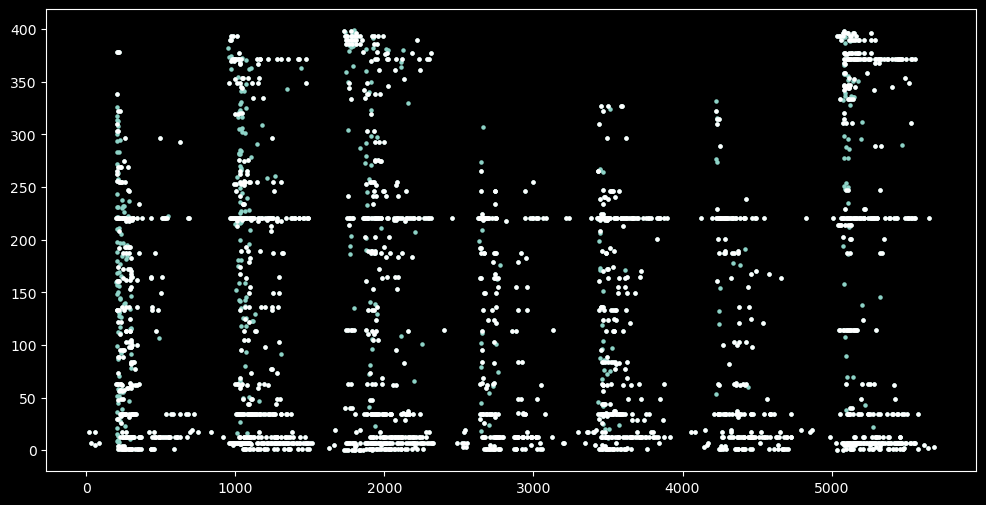

In [69]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>=2][np.where(sanity_check[:,patterns[counts>=2]]==1)[1]], np.where(sanity_check[:,patterns[counts>=2]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

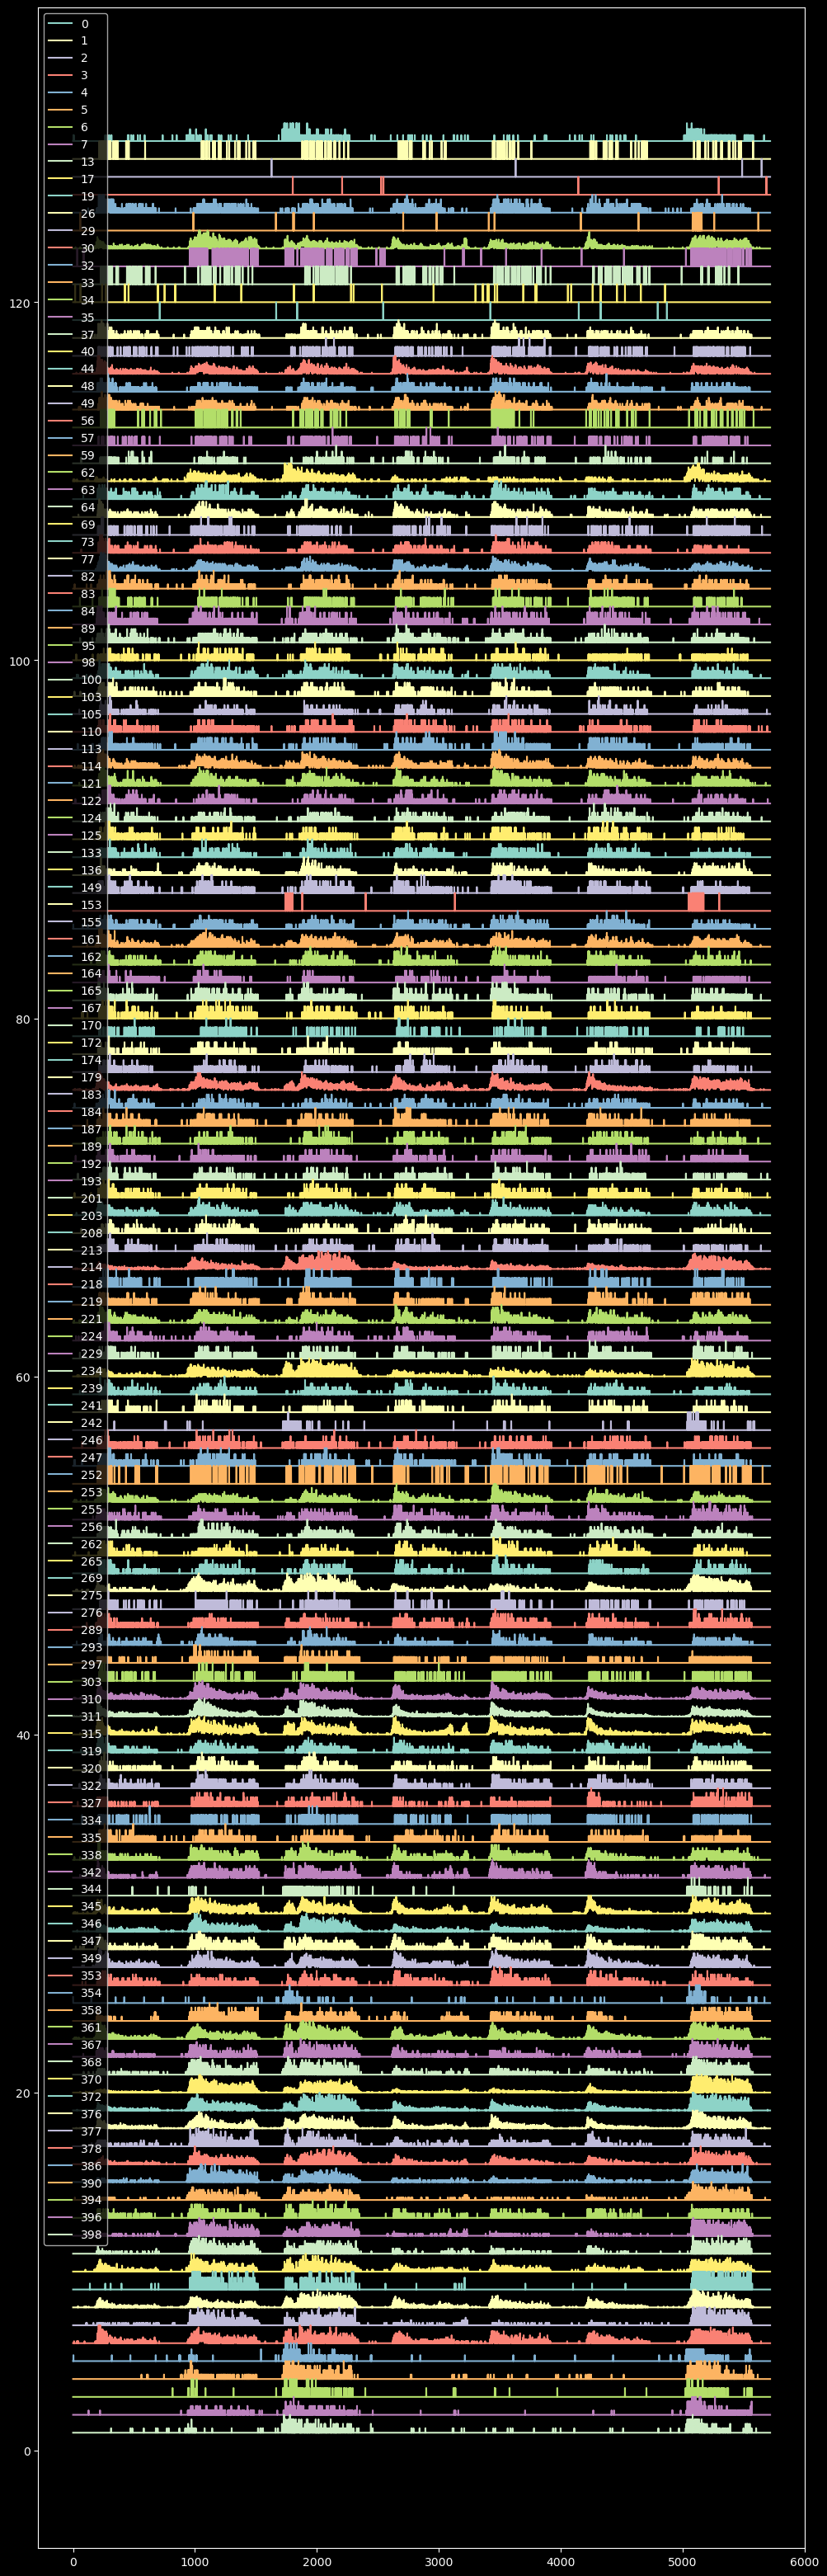

In [70]:
plt.figure(figsize=(12,40))
for i,k in enumerate(patterns[counts>=2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>=2])-i,label=k)
    plt.legend()
plt.show()

# Now let's look at spoken digits that are NOT 0

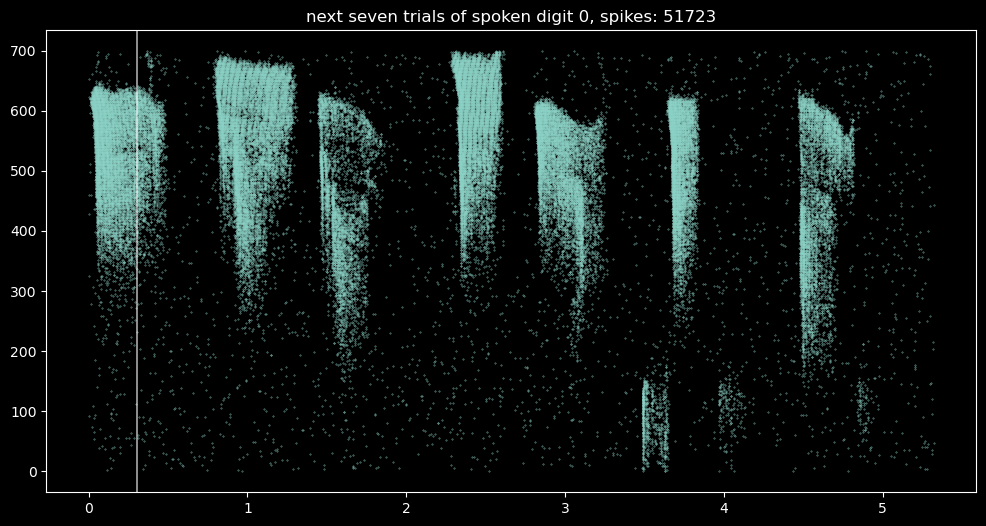

In [71]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))

idc = np.where((np.array(f['labels'])!=0))[0][3:10]

D=5/1000
times = np.array([0])
units = np.array([])
for i in idc:
    times = np.hstack((times, np.max(times)+f['spikes']['times'][i]))
    units = np.hstack((units, f['spikes']['units'][i]))
speaker = f['extra']['speaker'][i]
number = f['labels'][i]
units = units.astype('int')
times = np.delete(times,0)
plt.scatter(times ,units,s=0.1,alpha=0.9)
plt.axvline(0.3,linewidth=0.4)
plt.axvline(0.3+D,linewidth=0.4)

# plt.title(f'idc:{idc}, speaker: {speaker}, number: {number}, spikes: {len(times)}')
plt.title(f'next seven trials of spoken digit 0, spikes: {len(times)}')

plt.show()

In [72]:
raster = np.zeros((max((times*1000).astype('int'))+1, 1+max(units)))
print(raster.shape, pattern_img.shape)
for i in range(len(times)):
    raster[int(times[i]*1000),units[i]-1]=1
print('done')

D_ = pattern_img.shape[1]
sanity_check = np.zeros((raster.shape[0],pattern_img.shape[2]))
for j in tqdm(range(pattern_img.shape[2])):
    for i in range(raster.shape[0]-D_):
        sanity_check[i,j] = np.sum(pattern_img[...,j]*raster.T[:,i:i+D_])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

(5325, 700) (700, 19, 400)
done


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:13<00:00,  5.43it/s]


In [73]:
counts = np.array([list(np.where(sanity_check==1)[1]).count(k) for k in np.unique(np.where(sanity_check==1)[1])])
patterns = np.unique(np.where(sanity_check==1)[1])
pattern_template = np.array(pattern_template,dtype='object')
np.array(patterns[counts>=2]), np.array(counts[counts>=2]), np.array([len(k) for k in pattern_template[patterns[counts>=2]]])

(array([  0,   1,   2,   3,   5,   6,   7,   8,  11,  12,  17,  19,  21,
         23,  24,  26,  27,  29,  32,  33,  34,  37,  39,  41,  43,  49,
         52,  55,  60,  62,  64,  66,  68,  69,  71,  76,  77,  80,  82,
         83,  84,  85,  86,  87,  88,  89,  91,  94,  96,  98, 101, 103,
        104, 106, 107, 109, 111, 112, 113, 114, 115, 116, 117, 119, 120,
        127, 128, 130, 134, 139, 146, 147, 149, 150, 159, 161, 162, 163,
        164, 165, 167, 170, 172, 176, 178, 179, 181, 183, 185, 189, 191,
        192, 193, 195, 197, 204, 205, 207, 208, 213, 218, 219, 221, 223,
        227, 228, 229, 231, 237, 238, 239, 241, 242, 246, 252, 253, 255,
        259, 261, 263, 264, 266, 273, 275, 276, 280, 287, 288, 292, 293,
        297, 301, 303, 305, 307, 310, 311, 320, 323, 324, 327, 330, 335,
        340, 341, 343, 344, 349, 351, 353, 354, 356, 359, 361, 365, 366,
        367, 372, 378, 380, 382, 386, 388, 390, 392, 396, 397, 398, 399],
       dtype=int64),
 array([  5, 136,   5,  16,  

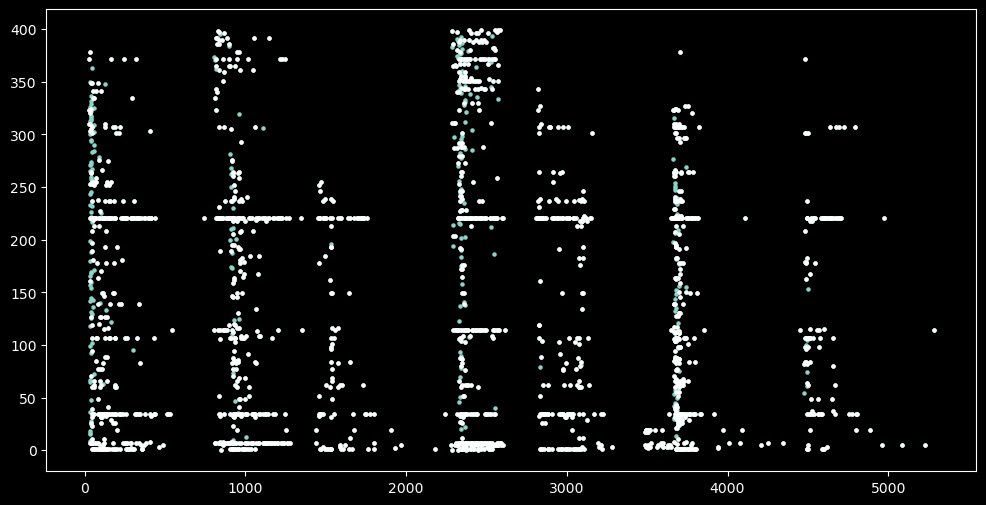

In [76]:
plt.figure(figsize=(12,6))
plt.scatter(*np.where(sanity_check==1), s=5)
y,x = patterns[counts>=2][np.where(sanity_check[:,patterns[counts>=2]]==1)[1]], np.where(sanity_check[:,patterns[counts>=2]]==1)[0]
plt.scatter(x,y, c='white',s=5)
plt.show()

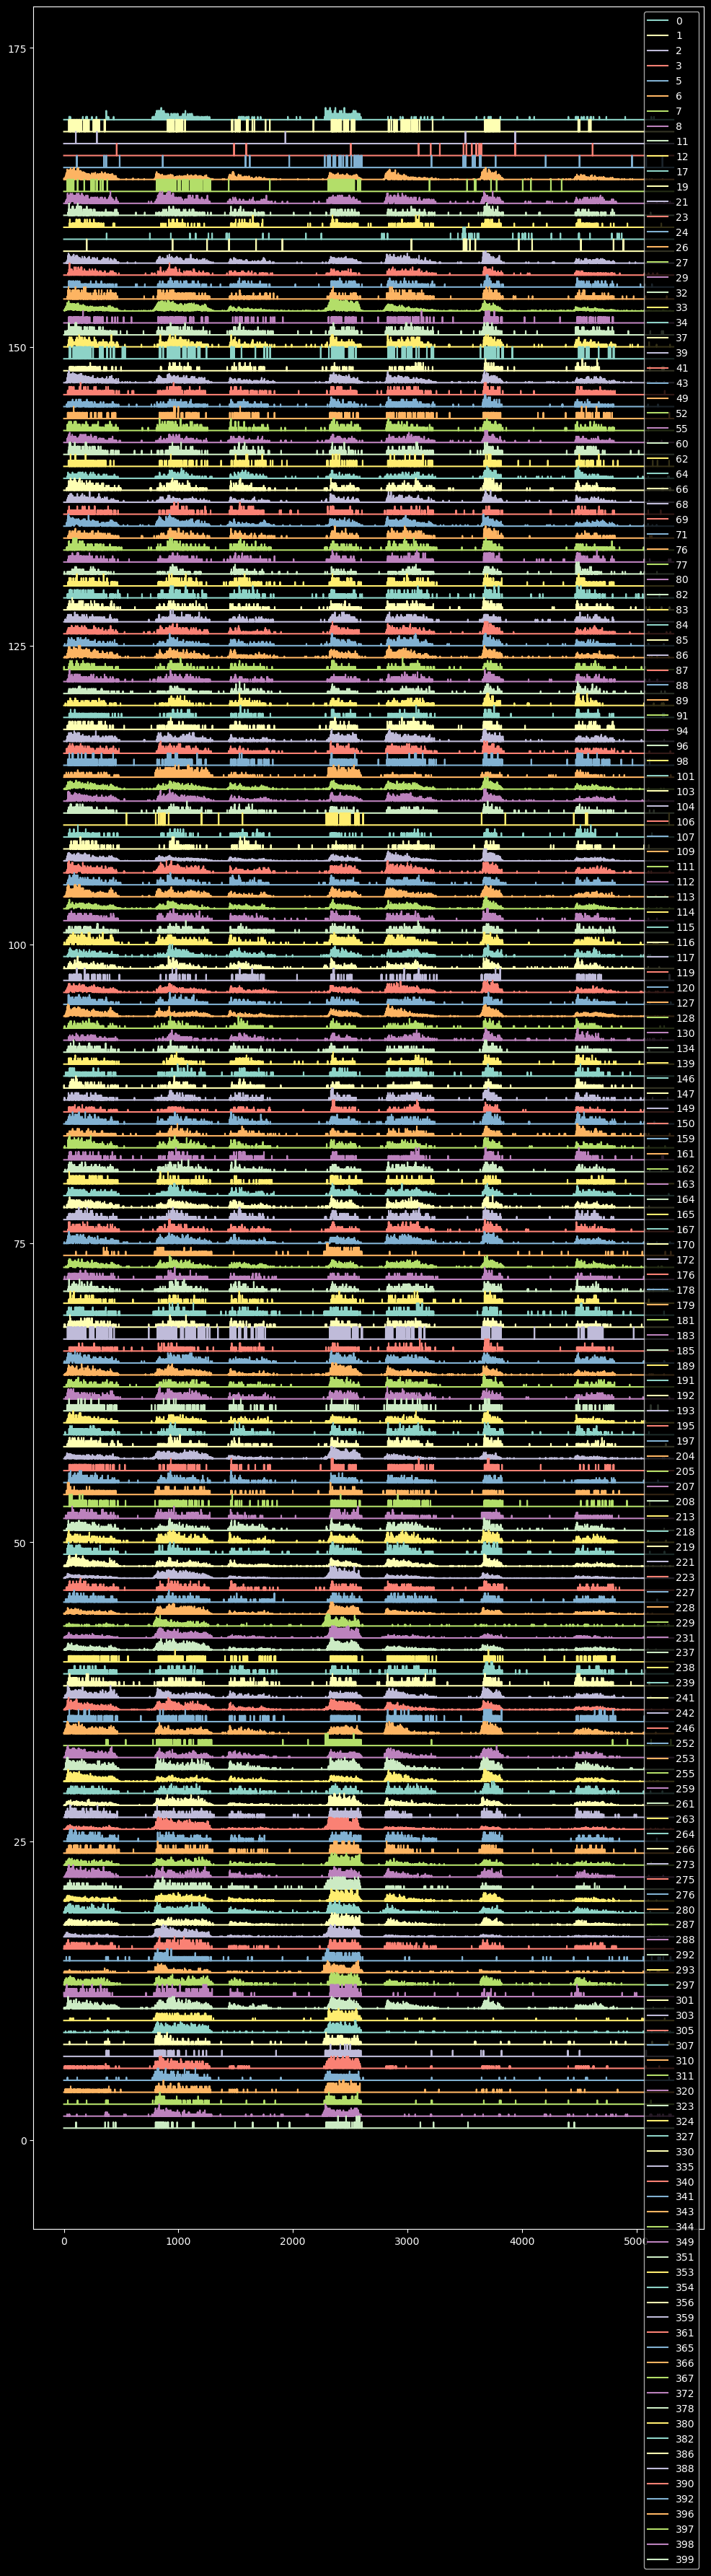

In [77]:
plt.figure(figsize=(12,40))
for i,k in enumerate(patterns[counts>=2]):
    plt.plot(sanity_check[:,k]+len(patterns[counts>=2])-i,label=k)
    plt.legend()
plt.show()